# How to solve 90% of NLP problems: a step-by-step guide

While there exist a wealth of elaborate and abstract NLP techniques, clustering and classification should always be in our toolkit as the first techniques to use when dealing with this kind of data. In addition to being amongst some of the easiest to scale in production, their ease of use can quickly help business address a set of applied problems:

* How do you automatically make the distinction between different categories of sentences?
* How can you find sentences in a dataset that are most similar to a given one?
* How can you extract a rich and concise representation that can then be used for a range of other tasks?
* Most importantly, how do you find quickly whether these tasks are possible on your dataset at all?

## Our Dataset: Disasters on social media
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous). 
<br>
[Download](https://www.crowdflower.com/data-for-everyone/)
<br>
search: Disasters on social media

## Why it matters
We will try to correctly predict tweets that are about disasters. This is a very relevant problem, because:

* It is actionable to anybody trying to get signal from noise (such as police departments in this case)
* It is tricky because relying on keywords is harder than in most cases like spam

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

Using TensorFlow backend.


## Sanitizing input
Let's make sure our tweets only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

In [18]:
path = "D:/Program/dataset/socialmedia-disaster-tweets/"
ori_filename = path+"socialmedia_relevant_cols.csv"
filename = path+"socialmedia_relevant_cols_clean.csv"

input_file = codecs.open(ori_filename, "r", encoding='utf-8', errors='replace')
output_file = codecs.open(filename, "w", encoding='utf-8')

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
                         
sanitize_characters(input_file, output_file)

In [24]:
questions = pd.read_csv(filename)
c = ['text', 'choose_one', 'choose_one:confidence']
questions = questions[c]
questions.head()

,text,choose_one,choose_one:confidence
0,Just happened a terrible car crash,Relevant,1.0000
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1.0000
2,"Heard about #earthquake is different cities, s...",Relevant,1.0000
3,"there is a forest fire at spot pond, geese are...",Relevant,0.9603
4,Forest fire near La Ronge Sask. Canada,Relevant,1.0000


In [25]:
questions.tail()

,text,choose_one,choose_one:confidence
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,0.7629
10872,Police investigating after an e-bike collided ...,Relevant,0.9203
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1.0000
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,0.8419
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,0.8812


In [26]:
questions.describe()

,choose_one:confidence
count,10876.000000
mean,0.842037
std,0.168086
min,0.334200
25%,0.714900
50%,0.804900
75%,1.000000
max,1.000000


Let's use a few regular expressions to clean up pour data, and save it back to disk for future use

In [27]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv(path+"clean_data.csv")
questions.head()

,text,choose_one,choose_one:confidence
0,just happened a terrible car crash,Relevant,1.0000
1,our deeds are the reason of this earthquake m...,Relevant,1.0000
2,"heard about earthquake is different cities, s...",Relevant,1.0000
3,"there is a forest fire at spot pond, geese are...",Relevant,0.9603
4,forest fire near la ronge sask canada,Relevant,1.0000


In [28]:
clean_questions = pd.read_csv(path+"clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,choose_one:confidence
10871,10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,0.7629
10872,10872,police investigating after an e bike collided ...,Relevant,0.9203
10873,10873,the latest more homes razed by northern calif...,Relevant,1.0000
10874,10874,meg issues hazardous weather outlook (hwo),Relevant,0.8419
10875,10875,cityofcalgary has activated its municipal eme...,Relevant,0.8812


## Data Overview
Let's look at our class balance.

In [30]:
clean_questions.groupby("choose_one:confidence").count()

,Unnamed: 0,text,choose_one
choose_one:confidence,,,
0.3342,1,1,1
0.3367,1,1,1
0.3982,1,1,1
0.3994,4,4,4
0.3995,2,2,2
0.3998,1,1,1
0.3999,2,2,2
0.4000,3,3,3
0.4001,2,2,2


### Our data is clean, now it needs to be prepared
Now that our inputs are more reasonable, let's transform our inputs in a way our model can understand. This implies:

* Tokenizing sentences to a list of separate words
* Creating a train test split
* Inspecting our data a little more to validate results

In [31]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,choose_one:confidence,tokens
0,0,just happened a terrible car crash,Relevant,1.0000,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1.0000,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1.0000,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,0.9603,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1.0000,"[forest, fire, near, la, ronge, sask, canada]"


### Inspecting our dataset a little more

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154703 words total, with a vocabulary size of 18097
Max sentence length is 34


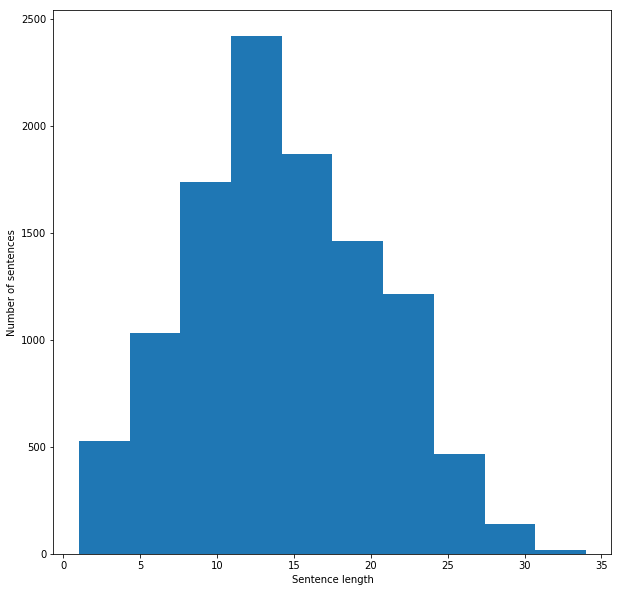

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()